In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 

import sys
sys.path.append(f'/home/beans/bespoke')
from constants import *

import matplotlib.pyplot as plt
from viz_utils import draw_wps
from loaders import *
from constants import *
from imports import *
from models import *
from viz_utils import *
torch.__version__

'1.13.1'

In [2]:
%%time
loader = TrnLoader(bs=32) # 1200

Launching 3 loader workers


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been depreca

Got first chunk
CPU times: user 41 ms, sys: 177 ms, total: 218 ms
Wall time: 2.2 s


Process Process-3:
Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/beans/bespoke/loaders.py", line 130, in make_chunks
    time.sleep(.1)
  File "/home/beans/bespoke/loaders.py", line 130, in make_chunks
    time.sleep(.1)
  Fil

In [3]:
%%time
batch = loader.get_batch()
img, aux, wps, (to_pred_mask, is_first_in_seq) = batch


CPU times: user 913 ms, sys: 688 ms, total: 1.6 s
Wall time: 2.56 s


In [11]:
from norm import *
b_ix = 2
_img = (denorm_img(img[b_ix][0].permute(1,2,0).detach().cpu().numpy()) * 255).astype('uint8')
_img.shape

(360, 1440, 4)

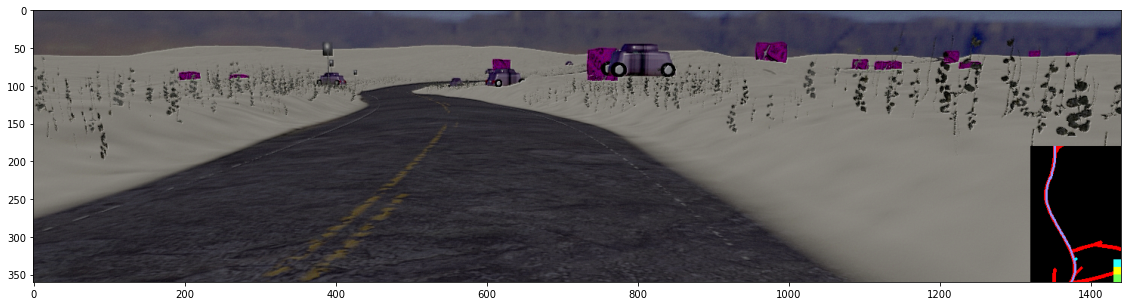

In [12]:
plt.figure(figsize=(20,5))
plt.imshow(_img[:,:,:3])

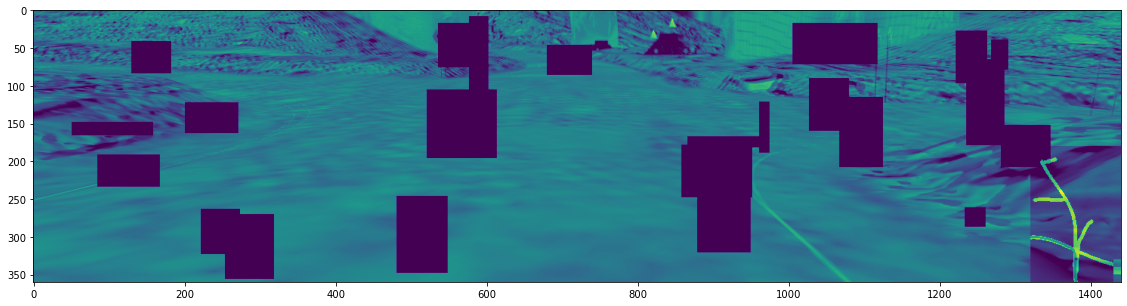

In [8]:
plt.figure(figsize=(20,5))
plt.imshow(_img[:,:,3:]//2 + _img[:,:,:1]//2)

In [10]:
m = EffNet().to(device) 
model_stem = "" #"1.23_e199"
m.load_state_dict(torch.load(f"{BESPOKE_ROOT}/models/m{model_stem}.torch"), strict=False)
m.save_backbone_out = True
m.set_for_viz() # comment out hooks in model to test this path
m.eval()
sum([torch.numel(p) for p in m.parameters()]) / 1000

RuntimeError: Error(s) in loading state_dict for EffNet:
	size mismatch for backbone.conv_stem.weight: copying a param with shape torch.Size([48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([48, 4, 3, 3]).

In [6]:
actgrad = get_actgrad(m, img, aux_model, aux_calib, actgrad_target='traj')
actgrad.shape

(360, 1440, 1)

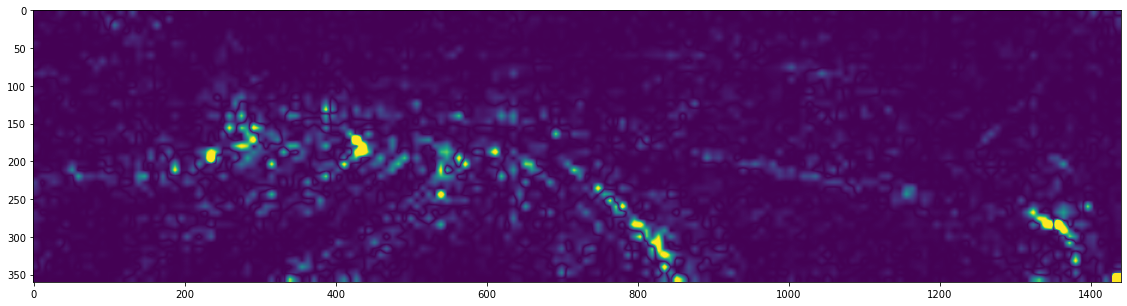

In [7]:
plt.figure(figsize=(20,5))
plt.imshow(actgrad.astype(np.float32))

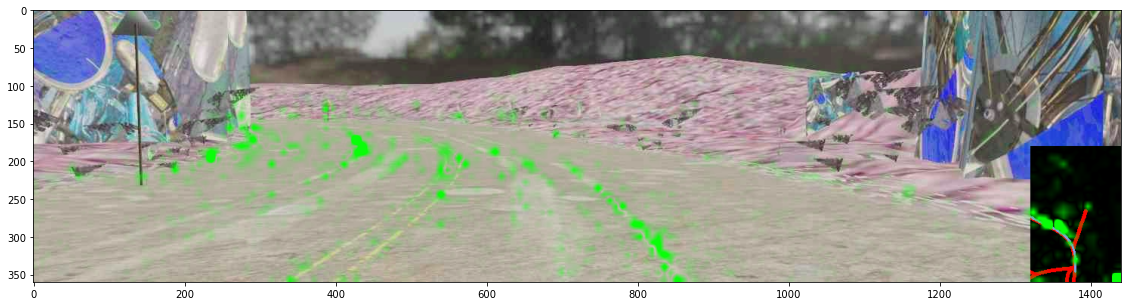

In [8]:
img_actgrad = combine_img_actgrad(_img[:,:,:3], actgrad)
plt.figure(figsize=(20,5))
plt.imshow(img_actgrad)

In [9]:
m

EffNet(
  (backbone): Sequential(
    (0): Conv2d(4, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    

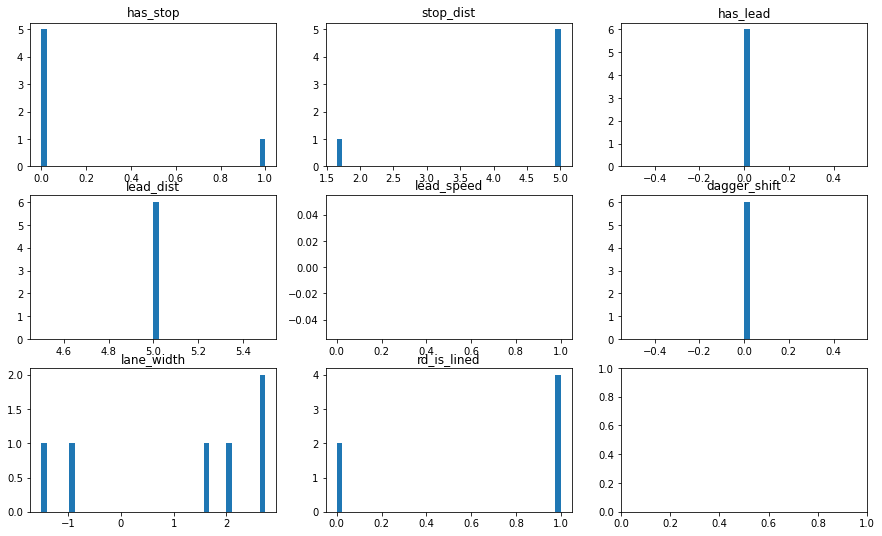

In [22]:
aux_np = na(aux.detach().cpu().numpy(), AUX_PROPS)
plot_aux(aux_np, AUX_TARGET_PROPS)

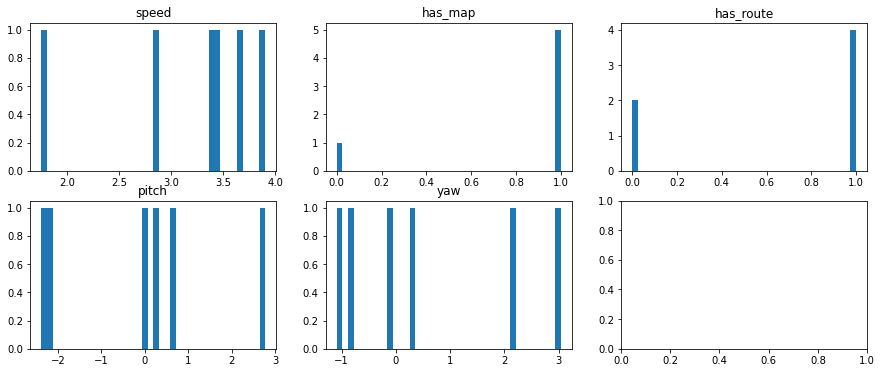

In [23]:
plot_aux(aux_np, AUX_MODEL_PROPS)

In [20]:
wp_angles, wp_headings, wp_curvatures, wp_rolls, wp_zs = np.split(wps.detach().cpu().numpy(), 5, -1)
wp_angles.shape, wp_headings.shape, wp_curvatures.shape, wp_rolls.shape, wp_zs.shape

((6, 1, 30), (6, 1, 30), (6, 1, 30), (6, 1, 30), (6, 1, 30))

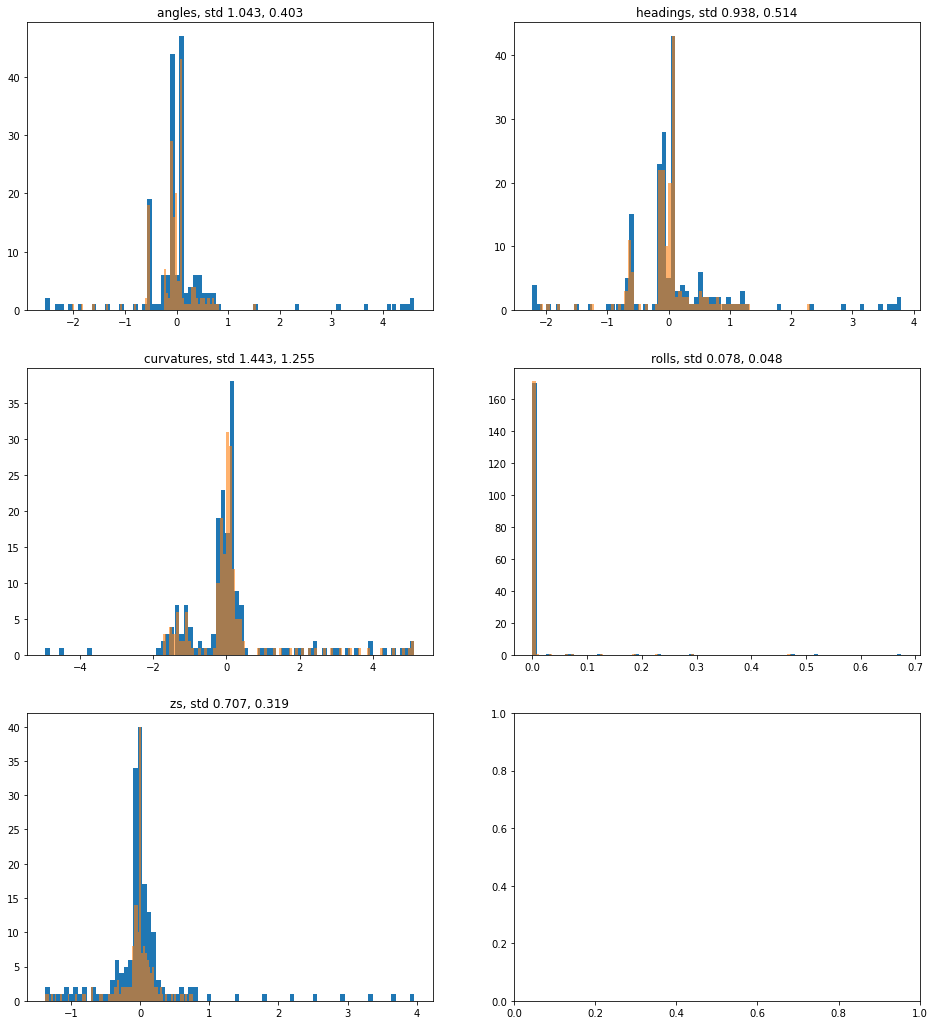

In [21]:
plot_wps([wp_angles, wp_headings, wp_curvatures, wp_rolls, wp_zs], to_pred_mask.detach().cpu().numpy())

In [33]:
to_pred_mask.sum() / to_pred_mask.numel()

tensor(0.9005, device='cuda:0')

In [16]:
m.backbone

Sequential(
  (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
  (3): Sequential(
    (0): DepthwiseSeparableConv(
      (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (se): SqueezeExcite(
        (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
        (act1): SiLU(inplace=True)
        (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        (gate): Sigmoid()
      )
      (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): Identity()
    )
    (1): DepthwiseSeparableConv(
      (conv_dw): Conv2d(24, 2

In [8]:
m.train()

EffNet(
  (backbone): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    

In [9]:
%%time
with torch.no_grad():
    with torch.cuda.amp.autocast(): 
        wps_p, aux_targets_p, obsnet_out  = m(img, aux)

0 isnan:0 max:102.6875 min:-98.625 std:6.234375 mean:0.034576416015625 torch.Size([6, 48, 180, 720])
1 isnan:0 max:237.5 min:-200.125 std:4.73828125 mean:3.333984375 torch.Size([6, 48, 180, 720])
2 isnan:0 max:237.5 min:-0.278564453125 std:4.2265625 mean:3.5703125 torch.Size([6, 48, 180, 720])
3 isnan:0 max:349.0 min:-1176.0 std:13.7734375 mean:-1.1376953125 torch.Size([6, 24, 180, 720])
4 isnan:0 max:1062.0 min:-493.5 std:22.078125 mean:-1.2646484375 torch.Size([6, 32, 90, 360])
5 isnan:0 max:734.0 min:-454.5 std:18.28125 mean:-0.9619140625 torch.Size([6, 56, 45, 180])
6 isnan:0 max:375.5 min:-445.75 std:16.078125 mean:0.2391357421875 torch.Size([6, 112, 23, 90])
7 isnan:0 max:405.25 min:-402.0 std:16.8125 mean:-0.44482421875 torch.Size([6, 160, 23, 90])
8 isnan:0 max:258.5 min:-237.875 std:24.703125 mean:-0.94482421875 torch.Size([6, 272, 12, 45])
9 isnan:0 max:655.0 min:-392.25 std:8.84375 mean:-0.70703125 torch.Size([6, 448, 12, 45])
10 isnan:0 max:54784.0 min:-15128.0 std:879.5 me

In [18]:
aux.mean(), aux.std()

(tensor(3.9688, device='cuda:0', dtype=torch.float16),
 tensor(17.6094, device='cuda:0', dtype=torch.float16))

In [12]:
obsnet_out

tensor([[[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]]], device='cuda:0', dtype=torch.float16)

In [31]:
for (n,p) in m.named_parameters():
    if ".bn" in n:
        print(n, p.max().item(), p.min().item(), p.std().item(), p.mean().item())

backbone.3.0.bn1.weight 10.247492790222168 -9.334823608398438 4.19589376449585 3.3274588584899902
backbone.3.0.bn1.bias 24.652915954589844 -5.2129082679748535 5.130411148071289 3.01467227935791
backbone.3.0.bn2.weight 24.931732177734375 0.14150160551071167 7.543893814086914 13.506982803344727
backbone.3.0.bn2.bias 5.976871490478516 -5.3035478591918945 2.6093966960906982 -0.3156040906906128
backbone.3.1.bn1.weight 8.648701667785645 -1.2818788290023804 2.034669876098633 3.5026321411132812
backbone.3.1.bn1.bias 14.378236770629883 -3.3664143085479736 4.873565673828125 4.470156669616699
backbone.3.1.bn2.weight 21.81593132019043 6.6512675285339355 4.2342634201049805 12.082923889160156
backbone.3.1.bn2.bias 12.599742889404297 -7.91371488571167 4.783146381378174 -0.9087821245193481
backbone.4.0.bn1.weight 14.83806037902832 -0.8084381222724915 4.029274940490723 3.910146951675415
backbone.4.0.bn1.bias 9.782878875732422 -7.523768424987793 2.474703788757324 1.5215429067611694
backbone.4.0.bn2.weig

In [23]:
sum([p.isnan().sum().item() for n,p in m.named_parameters()])

0

(array([8.0000e+00, 1.0625e+04, 7.7000e+01, 1.9000e+01, 8.0000e+00,
        3.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([-0.167  , -0.06714,  0.0327 ,  0.1326 ,  0.2324 ,  0.3323 ,
         0.4321 ,  0.532  ,  0.632  ,  0.7314 ,  0.8315 ], dtype=float16),
 <BarContainer object of 10 artists>)

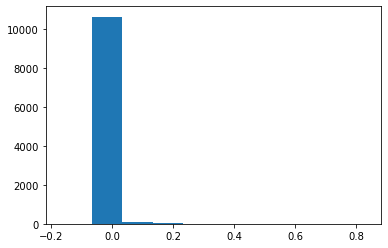

In [30]:
plt.hist(m.backbone_out_acts.detach().cpu().numpy().flatten())

In [28]:
aux.isnan().sum()

tensor(0, device='cuda:0')

In [8]:
m.load_trt_backbone()

In [20]:
# randoms
img = torch.randn((1,1, N_CHANNELS, IMG_HEIGHT, IMG_WIDTH)).to(device)
aux_model = torch.randn((1,1, N_AUX_MODEL_IN)).to(device)
aux_calib = torch.randn((1,1, N_AUX_CALIB_IN)).to(device)

In [19]:
%%time
with torch.no_grad():
    wps_preds, aux_preds, obs_net_out  = m(img, aux_model, aux_calib)

NameError: name 'aux_model' is not defined

In [8]:
import subprocess

In [9]:
# Load up membank from ssd to shm
subprocess.run("cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank", shell=True)

CompletedProcess(args='cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank', returncode=0)

In [ ]:
# save membank to ssd
subprocess.run("cp -R /dev/shm/blender_membank /media/beans/beans_data/blender_membank", shell=True)